In [7]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [2]:
#import matlab.engine
import numpy as np;
from sklearn.neighbors import KDTree
import FactorBP as FB
from scipy.spatial import Delaunay
import scipy.io as sio
from Utils import *
import time

def ComputeAccuracyPas(decode, gTruth, NofInliers ):
    Ccnt = 0
    for i in range(NofInliers):
        if(decode[i] == gTruth[i]):
            Ccnt += 1
    return 1.0 * Ccnt / NofInliers
# eng = matlab.engine.start_matlab()
CarData = LoadCar()

NofAlgorithms = 9
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA']
MaxNofOus = 20
MeanAcc = np.zeros([MaxNofOus + 1, NofAlgorithms ])
MeanRtime = np.zeros([MaxNofOus + 1, NofAlgorithms])
MeanObj = np.zeros([MaxNofOus + 1, NofAlgorithms])

np.random.seed(123456)
NofInstances = 30


for NofOus in range(0,MaxNofOus+1):
    Accuracy = np.zeros([NofAlgorithms, NofInstances])
    Rtime = np.zeros([NofAlgorithms, NofInstances])
    Obj = np.zeros([NofAlgorithms, NofInstances])
    for idx in range(1, NofInstances + 1):
        
        car1 = CarData[idx]
        LocalFeature1 = car1['features1']
        LocalFeature2 = car1['features2']
        
        PT1 = LocalFeature1[:, 0:2]
        PT2 = LocalFeature2[:, 0:2]
        
        
        orientation1 = LocalFeature1[:, 8]
        orientation2 = LocalFeature2[:, 8]
        
        GT = car1['gTruth'][0]
        
        NofInliers = len(GT)
        CMaxNofOus = np.min([LocalFeature1.shape[0], LocalFeature2.shape[0]]) - NofInliers
        CNofOus = NofOus
        if(CNofOus > CMaxNofOus):
            CNofOus = CMaxNofOus
        NofNodes = CNofOus + NofInliers
        gTruth = np.random.permutation(NofNodes)
        PT1 = PT1[gTruth, :]
        orientation1 = orientation1[gTruth]
        MG1 = FB.MatchingGraph(PT1[0:NofNodes], orientation1[0:NofNodes])
        MG2 = FB.MatchingGraph(PT2[0:NofNodes], orientation2[0:NofNodes])

        G = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        
        G2 = FB.ConstructMatchingModel(MG1, MG2, 'pas', False)
        Gvis = FB.ConstructMatchingModel(MG1, MG2, 'pas', True)
        
        

        
        
        
        
        G.SetVerbose(False)
        
        res1 = FB.BaBSolver(G, 30, 10, 0.005, False)
        res2 = FB.BaBSolver(G2, 100, 10, 0.005, False)


        resBag = eng.runBcagm(nargout=3)
        resBagMP = eng.runBcagmQuad1(1,nargout=3)
        resBagIPFP = eng.runBcagmQuad1(2,nargout=3)
        resHGM = eng.runHGM(nargout=3)
        resRRWHM = eng.runRRWHM(nargout=3)
        resTM = eng.runTensorMatching(nargout=3)
        
        
        
        start_time = time.time()
        ResForBca = sio.loadmat('Temp.mat')
        X0 = np.zeros(NofNodes)
        X0Vec = res1.Decode
        for i in xrange(NofNodes):
            X0[i] = X0Vec[i]
        ResForBca['X0'] = X0
        sio.savemat('Temp.mat', ResForBca)
        resOursBCA = eng.runBcagm(nargout=3)
        time_dur = time.time() - start_time
        
        ImageI = idx - 1
        cDecode = FB.intArray(NofNodes)
        #print(resOursBCA[1][0])
        for i in range(NofNodes):
            cDecode[i] = int(resOursBCA[1][0][i])
        if(res1.Value < Gvis.ComputeObj(cDecode)):
            Accuracy[8][ImageI] = ComputeAccuracyPas(resOursBCA[1][0], gTruth, NofInliers)
            Obj[8][ImageI] = Gvis.ComputeObj(cDecode)
        else:
            Accuracy[8][ImageI] = ComputeAccuracyPas(res1.Decode, gTruth, NofInliers)
            Obj[8][ImageI] = res1.Value


        
        Rtime[8][ImageI] = time_dur + res1.Time
        
        
        ImageI = idx - 1
        Accuracy[0][ImageI] = ComputeAccuracyPas(res1.Decode, gTruth, NofInliers)
        Rtime[0][ImageI] = res1.Time
        Obj[0][ImageI] = res1.Value
        
        Accuracy[7][ImageI] = ComputeAccuracyPas(res2.Decode, gTruth, NofInliers)
        Rtime[7][ImageI] = res2.Time
        Obj[7][ImageI] = res2.Value

        Accuracy[1][ImageI] = ComputeAccuracyPas(resBag[1][0], gTruth, NofInliers)
        Rtime[1][ImageI] = resBag[0]
        cDecode = FB.intArray(NofNodes)
        for i in range(NofNodes):
            cDecode[i] = int(resBag[1][0][i])
        Obj[1][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[2][ImageI] = ComputeAccuracyPas(resBagMP[1][0], gTruth, NofInliers)
        Rtime[2][ImageI] = resBagMP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagMP[1][0][i])
        Obj[2][ImageI] = Gvis.ComputeObj(cDecode)
        
        Accuracy[3][ImageI] = ComputeAccuracyPas(resBagIPFP[1][0], gTruth, NofInliers)
        Rtime[3][ImageI] = resBagIPFP[0]
        for i in range(NofNodes):
            cDecode[i] = int(resBagIPFP[1][0][i])
        Obj[3][ImageI] = Gvis.ComputeObj(cDecode)
        
        
        Accuracy[4][ImageI] = ComputeAccuracyPas(resHGM[1][0], gTruth, NofInliers)
        Rtime[4][ImageI] = resHGM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resHGM[1][0][i])
        Obj[4][ImageI] = Gvis.ComputeObj(cDecode)
        
        
        Accuracy[5][ImageI] = ComputeAccuracyPas(resRRWHM[1][0], gTruth, NofInliers)
        Rtime[5][ImageI] = resRRWHM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resRRWHM[1][0][i])
        Obj[5][ImageI] = Gvis.ComputeObj(cDecode)

        Accuracy[6][ImageI] = ComputeAccuracyPas(resTM[1][0], gTruth, NofInliers)
        Rtime[6][ImageI] = resTM[0]
        for i in range(NofNodes):
            cDecode[i] = int(resTM[1][0][i])
        Obj[6][ImageI] = Gvis.ComputeObj(cDecode)

        MaxObj = np.max(Obj[:,ImageI])
        Obj[:,ImageI] /= MaxObj

        for ai in xrange(NofAlgorithms):
            print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                             Accuracy[ai][ImageI],
                                                            Rtime[ai][ImageI],
                                                            Obj[ai][ImageI]))
        print('NofOus %d, Finished Frame: %d' % (NofOus,ImageI) )
    #Todo Ours-BCA
    for ai in xrange(NofAlgorithms):
        MeanAcc[NofOus][ai] = np.mean(Accuracy[ai])
        MeanRtime[NofOus][ai] = np.mean(Rtime[ai])
        MeanObj[NofOus][ai] = np.mean(Obj[ai])
        print('%s Accuracy %f Running Time %f Obj %f' %(AlgorithmNames[ai], 
                                                        np.mean(Accuracy[ai]),
                                                        np.mean(Rtime[ai]),
                                                        np.mean(Obj[ai])))
        #G2.SetVerbose(False)
        #G1.Solve(400)
        #G2.Solve(400)
        #Accurancy[idx - 1] = ComputeAccuracyPas(G1.GetDecode(), gTruth, NofInliers)

        #print('%d %f %f' % (idx, ComputeAccuracyPas(G1.GetDecode(), gTruth, NofInliers),
        #                    ComputeAccuracyPas(G2.GetDecode(), gTruth, NofInliers)))
        #print(res.Time)
        #print(res.Value)

        #AccurancyPW[idx - 1] = ComputeAccuracyPas(G2.GetDecode(), gTruth, NofInliers)

        #print(ComputeAccuracyPas(resPW.Decode, NofInliers))
        #print(resPW.Time)
        #print(resPW.Value)
    #print('HyperAccurancy %f, PairwiseAccurancy %f' % (Accurancy.mean(), AccurancyPW.mean()))
    

Ours Accuracy 0.894737 Running Time 1.205948 Obj 1.000000
BCA Accuracy 0.894737 Running Time 0.065699 Obj 1.000000
BCA-MP Accuracy 1.000000 Running Time 0.073973 Obj 0.978188
BCA-IPFP Accuracy 1.000000 Running Time 0.008295 Obj 0.978188
HGM Accuracy 0.473684 Running Time 0.039051 Obj 0.318136
RRWHM Accuracy 0.368421 Running Time 1.418504 Obj 0.435362
TM Accuracy 0.526316 Running Time 0.081396 Obj 0.817010
OursPW Accuracy 0.578947 Running Time 0.786565 Obj 0.789151
Ours-BCA Accuracy 0.894737 Running Time 1.221792 Obj 1.000000
NofOus 0, Finished Frame: 0
Ours Accuracy 0.708333 Running Time 1.455929 Obj 1.000000
BCA Accuracy 0.583333 Running Time 0.008944 Obj 0.978506
BCA-MP Accuracy 0.708333 Running Time 0.057912 Obj 1.000000
BCA-IPFP Accuracy 0.583333 Running Time 0.020286 Obj 0.978506
HGM Accuracy 0.416667 Running Time 0.006431 Obj 0.451461
RRWHM Accuracy 0.333333 Running Time 0.094771 Obj 0.903956
TM Accuracy 0.166667 Running Time 0.035091 Obj 0.527393
OursPW Accuracy 0.708333 Running

In [ ]:
import pylab
%matplotlib inline


fig = pylab.figure()
figlegend = pylab.figure(figsize=(4,3))
ax = fig.add_subplot(111)


for ai in xrange(NofAlgorithms):
    line = plt.plot(range(0,NofOus+1), np.random.randn(NofOus+1), label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
    figlegend.legend(line, (AlgorithmNames[Seq[ai]]), 'upper center')




fig.show()
figlegend.show()
figlegend.savefig('legend.png')

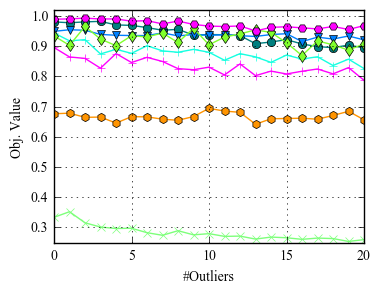

In [10]:



plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    if(AlgorithmNames[Seq[ai]] == 'OursPW'):
        continue
    plt.plot(range(0,NofOus+1), MeanObj[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
plt.ylim([0.25,1.02])
plt.ylabel('Obj. Value')
plt.xlabel('#Outliers')
plt.grid(True)
plt.savefig('Car_Obj.pdf')    # <-- loses transparency

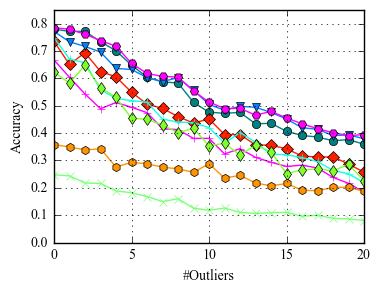

In [9]:
import matplotlib.pyplot as plt
import matplotlib
import pylab
%matplotlib inline


Colors = [[ 0.        ,  0.5        , 0.5        ,  1.        ],
          [ 1.        ,  0.00196078,  1.        ,  1.        ],
          [ 0.        ,  0.50392157,  1.        ,  1.        ],
          [ 0.08538899,  1.        ,  0.88235294,  1.        ],
          [ 0.49019608,  1.        ,  0.47754586,  1.        ],
          [ 0.5       ,  1.        ,  0.17273877,  1.        ],
          [ 1.        ,  0.58169935,  0.        ,  1.        ],
          [ 1.        ,  0.11692084,  0.        ,  1.        ],
          [ 1.        ,  0.        ,  1.        ,  1.        ]];
Seq = [0, 7, 1, 2, 3, 4, 5, 6, 8]
AlgorithmNames=['Ours', 'BCA', 'BCA-MP', 'BCA-IPFP', 'HGM', 'RRWHM', 'TM', 'OursPW', 'Ours-BCA']
Markers = ['o', '+', 'v', '+', 'x', 'd', 'h', 'D', 'H']

figData = pylab.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
ax = pylab.gca()

matplotlib.rc('font',family='Times New Roman')


#plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')

for ai in xrange(NofAlgorithms):
    pylab.plot(range(0,NofOus+1), MeanAcc[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]])
pylab.ylim([0,0.85])
pylab.grid(True)

pylab.ylabel('Accuracy')
pylab.xlabel('#Outliers')


figLegend = pylab.figure(figsize = (11.7,0.4))
pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper center',  ncol=9, shadow=True, fancybox=True)
#figData.savefig('Car_Acc.pdf')
figLegend.savefig("legend.pdf")
figLegend.show()

#plt.legend(shadow=True, fancybox=True,loc='upper center', bbox_to_anchor=(0.5,-0.25), ncol=9)
#plt.savefig('House_ACC.pdf')    # <-- loses transparency

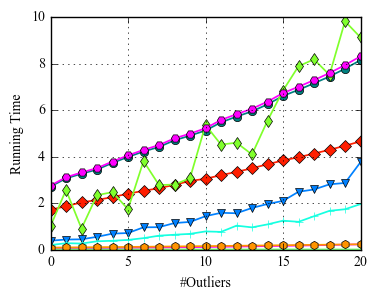

In [11]:


plt.figure(num=None, figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')


for ai in xrange(NofAlgorithms):
    plt.plot(range(0,NofOus+1), MeanRtime[:,Seq[ai]], label=AlgorithmNames[Seq[ai]], 
             color=Colors[Seq[ai]], marker=Markers[Seq[ai]], linewidth=1.25)

plt.ylabel('Running Time')
plt.xlabel('#Outliers')

plt.grid(True)
plt.savefig('Car_Time.pdf')    # <-- loses transparency

In [ ]:
import shelve



filename='shelve_car.out'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

In [ ]:
import cPickle as pickle
f = open("CarRes", "w")
pickle.dump(MeanAcc, f)
pickle.dump(MeanObj, f)
pickle.dump(MeanRtime, f)
f.close()

In [6]:
MeanAcc[0]

array([ 0.78013578,  0.66743213,  0.77133459,  0.74877446,  0.24770327,
        0.62199596,  0.35800952,  0.73539066,  0.78524089])